### Vectorized representation of words 
There are two ways to represent text data into numbers so that computer can understand that :
1. *One hot encoder* : One hot encoders are binary, sparse(mostly made of zeros), and very high dimensional(same dimensionality as the number of words in the vocabulary)
2. *Word Embeddings* : Word embeddings are low dimensional, floating point, dense vectors. So word embeddings pack more information into far fewer dimensions.

![](./data/images/OneHotvsWordEmbedding.png "OneHotvsWordEmbedding")

*One of the benefits of using dense and low-dimensional vectors is computational: the majority of neural network toolkits do not play well with very high-dimensional, sparse vectors. … The main benefit of the dense representations is generalization power: if we believe some features may provide similar clues, it is worthwhile to provide a representation that is able to capture these similarities.*

### Word2vec
<b>Word2vec</b> is a group of related models that are used to produce <b>word embeddings</b>. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.

![](./data/images/word2vec.png "Word2Vec")

There are two ways to obtain word embeddings :

1. <b>Train your own model from scratch</b>,In this setup you start with random word vectors and learn the word vectors in the same way you learn the weights of the neural netork.
2. Load into your model word embeddings that were precomputed using a different machine-lerning task.These are called <b>pretrained word embeddings</b>.

### Types of Word2Vec
Word2Vec is one of the most widely used form of word vector representation.

It has two variants:

1. CBOW (Continuous Bag of Words) : This model tries to predict a word on bases of it’s neighbours.
2. SkipGram : This models tries to predict the neighbours of a word.

![](./data/images/CBOWvsSkipGram.png "CBOWvsSkipGram")

### Gensim

Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Gensim provides the Word2Vec class for working with a Word2Vec model.

It only requires that the input must provide sentences sequentially, when iterated over. No need to keep everything in RAM: we can provide one sentence, process it, forget it, load another sentence.

Learning a word embedding from text involves loading and organizing the text into sentences and providing them to the constructor of a new Word2Vec() instance.


There are many parameters on this constructor; a few noteworthy arguments you may wish to configure are:

* size: (default 100) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word).
* window: (default 5) The maximum distance between a target word and words around the target word.
* min_count: (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.
* workers: (default 3) The number of threads to use while training.
* sg: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).

![](./data/images/word2vec_function.png "word2vec_function")

### Importing Libraries

In [191]:
import numpy as np
print('Numpy Version '+np.__version__)
import pandas as pd
print('Pandas Version '+pd.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
print('Tensorflow Version '+tf.__version__)
from IPython.display import Image # To view image from location/url
import keras
print('Keras Version '+keras.__version__)
import nltk
import logging
import multiprocessing
import re
import os
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

Numpy Version 1.12.1
Pandas Version 0.20.3
Tensorflow Version 1.1.0
Keras Version 2.1.3


#### Load Dateset

In [180]:
dataset = pd.read_csv('./data/reddit-small.txt',delimiter="/t",header=None)
dataset.head()

C:\Users\ab9bh\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,0
0,one has european accent either because doesn e...
1,mid twenties male rocking skinny jeans pants h...
2,honestly wouldn have believed didn live she ma...
3,money just driver license credit cards and sub...
4,smoking tobacco went from shitty pall malls ma...


#### Define Model

In [181]:
def train_model(inp, out, type=0):
    '''
    inp  : Input Dataset
    out  : Output Model
    type : 0(default) for CBOW & 1 for Skipgram
    '''
    logger = logging.getLogger("word2vect-training")
    logging.basicConfig(format="%(asctime)s:%(levelname)s:%(message)s")
    logging.root.setLevel(level=logging.INFO)
    
    model = Word2Vec(LineSentence(inp), size=100, window=5,min_count=5,workers=multiprocessing.cpu_count(),sg=type)
    model.init_sims(replace = True)
    model.save(out)

#### Train Model

In [182]:
train_model(inp = "./data/reddit-small.txt",
            out = "./data/word-vec_out"   )

2018-01-28 18:15:31,556:INFO:collecting all words and their counts
2018-01-28 18:15:31,558:INFO:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-01-28 18:15:31,613:INFO:collected 11440 word types from a corpus of 105198 raw words and 5000 sentences
2018-01-28 18:15:31,615:INFO:Loading a fresh vocabulary
2018-01-28 18:15:31,625:INFO:min_count=5 retains 2362 unique words (20% of original 11440, drops 9078)
2018-01-28 18:15:31,626:INFO:min_count=5 leaves 90968 word corpus (86% of original 105198, drops 14230)
2018-01-28 18:15:31,633:INFO:deleting the raw counts dictionary of 11440 items
2018-01-28 18:15:31,635:INFO:sample=0.001 downsamples 55 most-common words
2018-01-28 18:15:31,639:INFO:downsampling leaves estimated 70796 word corpus (77.8% of prior 90968)
2018-01-28 18:15:31,641:INFO:estimated required memory for 2362 words and 100 dimensions: 3070600 bytes
2018-01-28 18:15:31,649:INFO:resetting layer weights
2018-01-28 18:15:31,679:INFO:training model with 8 work

#### Load Model

In [183]:
model = Word2Vec.load("./data/word-vec_out")

2018-01-28 18:15:32,642:INFO:loading Word2Vec object from ./data/word-vec_out
2018-01-28 18:15:32,666:INFO:loading wv recursively from ./data/word-vec_out.wv.* with mmap=None
2018-01-28 18:15:32,667:INFO:setting ignored attribute syn0norm to None
2018-01-28 18:15:32,670:INFO:setting ignored attribute cum_table to None
2018-01-28 18:15:32,672:INFO:loaded ./data/word-vec_out


In [184]:
model['money']

array([-0.06854542, -0.01769976, -0.09515367,  0.03096126,  0.00821149,
       -0.06416579,  0.00101642,  0.13836809,  0.00839427, -0.22115941,
        0.03079663, -0.09771299,  0.22193618, -0.018597  , -0.08094473,
       -0.16754813, -0.1169207 ,  0.01273315, -0.15648776, -0.12346882,
       -0.06215186,  0.01429996,  0.02781461,  0.05705054,  0.10382451,
       -0.04648774, -0.15158863, -0.07078621, -0.0967006 ,  0.04931867,
        0.15376312, -0.12576272,  0.11089226,  0.0838503 ,  0.00627137,
        0.02884542, -0.03926311,  0.00528651,  0.00598842,  0.01050106,
        0.01517685,  0.16033773, -0.01629866,  0.08676878, -0.04818726,
       -0.05800617, -0.06216547,  0.04590269,  0.15841733, -0.20604222,
        0.11076346, -0.1463037 , -0.00769061,  0.16600636,  0.14374243,
        0.10583709,  0.01252565, -0.10380891,  0.06690776, -0.01935465,
        0.06301147,  0.04117782,  0.05851689, -0.06531125, -0.08376981,
        0.13010164,  0.01224598,  0.00066685, -0.08671875, -0.02

In [185]:
model.most_similar('women')

2018-01-28 18:15:32,699:INFO:precomputing L2-norms of word weight vectors


[('isn', 0.9998877644538879),
 ('probably', 0.9998847842216492),
 ('fact', 0.9998816251754761),
 ('money', 0.9998809099197388),
 ('true', 0.9998719692230225),
 ('enough', 0.9998701810836792),
 ('men', 0.9998665452003479),
 ('usually', 0.999866247177124),
 ('fucking', 0.9998658895492554),
 ('look', 0.9998653531074524)]

In [186]:
model.similarity('money','credit')

0.99963036434589903

#### Semantic similarity

In [187]:
def cosine_similarity(inp1, inp2):
    return np.dot(inp1, inp2) / (np.linalg.norm(inp1)*np.linalg.norm(inp2))

In [188]:
def average_similarity(text1, text2):
    # Lower and tokenize the words
    text1 = text1.lower().split()
    text2 = text2.lower().split()
    
    # Get a list of word vectors for each word in the sentence
    vector1 = np.array([model[word] for word in text1])
    vector2 = np.array([model[word] for word in text2])
    avg1_vector1 = np.mean(vector1,axis =0)
    avg1_vector2 = np.mean(vector2,axis =0)
    return cosine_similarity(avg1_vector1,avg1_vector2)

In [189]:
cosine_similarity([1,5],[5,6])

0.87885343166569463

In [190]:
average_similarity('money','love')

0.99986261

In [194]:
os.path

<module 'ntpath' from 'C:\\Users\\ab9bh\\Anaconda3\\envs\\tensorflow\\lib\\ntpath.py'>

In [195]:
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\ab9bh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.


True

Create a dictionary which translates words to integers and integers to words.

In [146]:
words = []
for word in corpus_raw.split():
    if word != '.': # because we don't want to treat . as a word
        words.append(word)
words = set(words) # so that all duplicate words are removed
word2int = {}
int2word = {}
vocab_size = len(words) # gives the total number of unique words
for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word
    
print(word2int)
print(int2word)    

{'he': 0, 'queen.king': 1, 'have': 2, 'is': 3, 'children': 4, 'she': 5, 'queen.': 6, 'king': 7, 'royal': 8, 'marries': 9, 'the': 10, 'two': 11, 'and': 12, 'queen': 13}
{0: 'he', 1: 'queen.king', 2: 'have', 3: 'is', 4: 'children', 5: 'she', 6: 'queen.', 7: 'king', 8: 'royal', 9: 'marries', 10: 'the', 11: 'two', 12: 'and', 13: 'queen'}


In [147]:
print(word2int['king'])
print(int2word[7])

7
king


In [148]:
# genereate list of sentences where each sentence is a list of words
raw_sentences = corpus_raw.split('.')
sentences = []
for sentence in raw_sentences:
    sentences.append(sentence.split())
print(sentences)

[['he', 'is', 'the', 'king'], ['the', 'king', 'is', 'royal'], ['she', 'is', 'the', 'royal', 'queen'], ['king', 'marries', 'queen'], ['king', 'and', 'queen', 'have', 'two', 'children']]


In [149]:
# Now, we will generate our training data
# This basically gives a list of word, word pairs with a window size of 2.

WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for word_index, word in enumerate(sentence):
        for nb_word in sentence[max(word_index - WINDOW_SIZE, 0) : min(word_index + WINDOW_SIZE, len(sentence)) + 1] : 
            if nb_word != word:
                data.append([word, nb_word])
                
                
print(data)                

[['he', 'is'], ['he', 'the'], ['is', 'he'], ['is', 'the'], ['is', 'king'], ['the', 'he'], ['the', 'is'], ['the', 'king'], ['king', 'is'], ['king', 'the'], ['the', 'king'], ['the', 'is'], ['king', 'the'], ['king', 'is'], ['king', 'royal'], ['is', 'the'], ['is', 'king'], ['is', 'royal'], ['royal', 'king'], ['royal', 'is'], ['she', 'is'], ['she', 'the'], ['is', 'she'], ['is', 'the'], ['is', 'royal'], ['the', 'she'], ['the', 'is'], ['the', 'royal'], ['the', 'queen'], ['royal', 'is'], ['royal', 'the'], ['royal', 'queen'], ['queen', 'the'], ['queen', 'royal'], ['king', 'marries'], ['king', 'queen'], ['marries', 'king'], ['marries', 'queen'], ['queen', 'king'], ['queen', 'marries'], ['king', 'and'], ['king', 'queen'], ['and', 'king'], ['and', 'queen'], ['and', 'have'], ['queen', 'king'], ['queen', 'and'], ['queen', 'have'], ['queen', 'two'], ['have', 'and'], ['have', 'queen'], ['have', 'two'], ['have', 'children'], ['two', 'queen'], ['two', 'have'], ['two', 'children'], ['children', 'have'], 

Convert training data to numbers(one hot vectors) so that computer can understand

In [150]:
# function to convert numbers to one hot vectors
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp
x_train = [] # input word
y_train = [] # output word
for data_word in data:
    x_train.append(to_one_hot(word2int[ data_word[0] ], vocab_size))
    y_train.append(to_one_hot(word2int[ data_word[1] ], vocab_size))
# convert them to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [151]:
print(x_train)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [152]:
print(x_train.shape, y_train.shape)

(58, 14) (58, 14)


Make the tensorflow model

In [153]:
# making placeholders for x_train and y_train
x = tf.placeholder(tf.float32, shape=(None, vocab_size))
y_label = tf.placeholder(tf.float32, shape=(None, vocab_size))

Convert training data  into the embedded representation.

![](./data/images/tensorflow.png "Word2Vec")

In [154]:
EMBEDDING_DIM = 5
W1 = tf.Variable(tf.random_normal([vocab_size, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([EMBEDDING_DIM])) #bias
hidden_representation = tf.add(tf.matmul(x,W1), b1)

Next, we take what we have in the embedded dimension and make a prediction about the neighbour. To make the prediction we use softmax.

![](./data/images/embeddings.png "Word2Vec")

In [155]:
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, vocab_size]))
b2 = tf.Variable(tf.random_normal([vocab_size]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_representation, W2), b2))

So to summarise:

![](./data/images/summary.png "Word2Vec")

input_one_hot  --->  embedded repr. ---> predicted_neighbour_prob
predicted_prob will be compared against a one hot vector to correct it.

Training time

In [156]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) #make sure you do this!
# define the loss function:
cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), reduction_indices=[1]))
# define the training step:
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy_loss)
n_iters = 10000
# train for n_iter iterations
for _ in range(n_iters):
    sess.run(train_step, feed_dict={x: x_train, y_label: y_train})
    print('loss is : ', sess.run(cross_entropy_loss, feed_dict={x: x_train, y_label: y_train}))

loss is :  6.48067
loss is :  5.81514
loss is :  5.3398
loss is :  4.98053
loss is :  4.69681
loss is :  4.46673
loss is :  4.27761
loss is :  4.12107
loss is :  3.99077
loss is :  3.88155
loss is :  3.78911
loss is :  3.70997
loss is :  3.64134
loss is :  3.58102
loss is :  3.52732
loss is :  3.47894
loss is :  3.43487
loss is :  3.39434
loss is :  3.35674
loss is :  3.32161
loss is :  3.28859
loss is :  3.2574
loss is :  3.2278
loss is :  3.19963
loss is :  3.17273
loss is :  3.14699
loss is :  3.1223
loss is :  3.09859
loss is :  3.07577
loss is :  3.05379
loss is :  3.0326
loss is :  3.01214
loss is :  2.99238
loss is :  2.97327
loss is :  2.95477
loss is :  2.93687
loss is :  2.91951
loss is :  2.90269
loss is :  2.88637
loss is :  2.87053
loss is :  2.85514
loss is :  2.8402
loss is :  2.82567
loss is :  2.81154
loss is :  2.79779
loss is :  2.78442
loss is :  2.77139
loss is :  2.7587
loss is :  2.74634
loss is :  2.73429
loss is :  2.72254
loss is :  2.71108
loss is :  2.69991


loss is :  1.81907
loss is :  1.81854
loss is :  1.818
loss is :  1.81747
loss is :  1.81694
loss is :  1.81641
loss is :  1.81588
loss is :  1.81535
loss is :  1.81482
loss is :  1.81429
loss is :  1.81377
loss is :  1.81324
loss is :  1.81271
loss is :  1.81219
loss is :  1.81166
loss is :  1.81114
loss is :  1.81061
loss is :  1.81009
loss is :  1.80957
loss is :  1.80904
loss is :  1.80852
loss is :  1.808
loss is :  1.80748
loss is :  1.80696
loss is :  1.80644
loss is :  1.80592
loss is :  1.8054
loss is :  1.80489
loss is :  1.80437
loss is :  1.80385
loss is :  1.80334
loss is :  1.80282
loss is :  1.8023
loss is :  1.80179
loss is :  1.80128
loss is :  1.80076
loss is :  1.80025
loss is :  1.79974
loss is :  1.79923
loss is :  1.79872
loss is :  1.7982
loss is :  1.79769
loss is :  1.79718
loss is :  1.79668
loss is :  1.79617
loss is :  1.79566
loss is :  1.79515
loss is :  1.79465
loss is :  1.79414
loss is :  1.79363
loss is :  1.79313
loss is :  1.79262
loss is :  1.79212


loss is :  1.58885
loss is :  1.58862
loss is :  1.58839
loss is :  1.58815
loss is :  1.58792
loss is :  1.58769
loss is :  1.58746
loss is :  1.58723
loss is :  1.587
loss is :  1.58678
loss is :  1.58655
loss is :  1.58632
loss is :  1.58609
loss is :  1.58587
loss is :  1.58564
loss is :  1.58541
loss is :  1.58519
loss is :  1.58497
loss is :  1.58474
loss is :  1.58452
loss is :  1.58429
loss is :  1.58407
loss is :  1.58385
loss is :  1.58363
loss is :  1.58341
loss is :  1.58319
loss is :  1.58297
loss is :  1.58275
loss is :  1.58253
loss is :  1.58231
loss is :  1.58209
loss is :  1.58187
loss is :  1.58166
loss is :  1.58144
loss is :  1.58122
loss is :  1.58101
loss is :  1.58079
loss is :  1.58058
loss is :  1.58036
loss is :  1.58015
loss is :  1.57994
loss is :  1.57972
loss is :  1.57951
loss is :  1.5793
loss is :  1.57909
loss is :  1.57888
loss is :  1.57867
loss is :  1.57846
loss is :  1.57825
loss is :  1.57804
loss is :  1.57783
loss is :  1.57762
loss is :  1.57

loss is :  1.51925
loss is :  1.51915
loss is :  1.51905
loss is :  1.51895
loss is :  1.51886
loss is :  1.51876
loss is :  1.51866
loss is :  1.51857
loss is :  1.51847
loss is :  1.51837
loss is :  1.51828
loss is :  1.51818
loss is :  1.51809
loss is :  1.51799
loss is :  1.51789
loss is :  1.5178
loss is :  1.5177
loss is :  1.51761
loss is :  1.51751
loss is :  1.51742
loss is :  1.51733
loss is :  1.51723
loss is :  1.51714
loss is :  1.51704
loss is :  1.51695
loss is :  1.51685
loss is :  1.51676
loss is :  1.51667
loss is :  1.51657
loss is :  1.51648
loss is :  1.51639
loss is :  1.51629
loss is :  1.5162
loss is :  1.51611
loss is :  1.51602
loss is :  1.51592
loss is :  1.51583
loss is :  1.51574
loss is :  1.51565
loss is :  1.51556
loss is :  1.51546
loss is :  1.51537
loss is :  1.51528
loss is :  1.51519
loss is :  1.5151
loss is :  1.51501
loss is :  1.51492
loss is :  1.51483
loss is :  1.51474
loss is :  1.51464
loss is :  1.51455
loss is :  1.51446
loss is :  1.514

loss is :  1.48782
loss is :  1.48778
loss is :  1.48773
loss is :  1.48768
loss is :  1.48764
loss is :  1.48759
loss is :  1.48755
loss is :  1.4875
loss is :  1.48746
loss is :  1.48741
loss is :  1.48736
loss is :  1.48732
loss is :  1.48727
loss is :  1.48723
loss is :  1.48718
loss is :  1.48714
loss is :  1.48709
loss is :  1.48705
loss is :  1.48701
loss is :  1.48696
loss is :  1.48692
loss is :  1.48687
loss is :  1.48683
loss is :  1.48678
loss is :  1.48674
loss is :  1.48669
loss is :  1.48665
loss is :  1.48661
loss is :  1.48656
loss is :  1.48652
loss is :  1.48647
loss is :  1.48643
loss is :  1.48639
loss is :  1.48634
loss is :  1.4863
loss is :  1.48626
loss is :  1.48621
loss is :  1.48617
loss is :  1.48613
loss is :  1.48608
loss is :  1.48604
loss is :  1.486
loss is :  1.48595
loss is :  1.48591
loss is :  1.48587
loss is :  1.48583
loss is :  1.48578
loss is :  1.48574
loss is :  1.4857
loss is :  1.48566
loss is :  1.48561
loss is :  1.48557
loss is :  1.4855

loss is :  1.47231
loss is :  1.47229
loss is :  1.47227
loss is :  1.47225
loss is :  1.47222
loss is :  1.4722
loss is :  1.47218
loss is :  1.47216
loss is :  1.47214
loss is :  1.47212
loss is :  1.4721
loss is :  1.47208
loss is :  1.47205
loss is :  1.47203
loss is :  1.47201
loss is :  1.47199
loss is :  1.47197
loss is :  1.47195
loss is :  1.47193
loss is :  1.47191
loss is :  1.47189
loss is :  1.47187
loss is :  1.47184
loss is :  1.47182
loss is :  1.4718
loss is :  1.47178
loss is :  1.47176
loss is :  1.47174
loss is :  1.47172
loss is :  1.4717
loss is :  1.47168
loss is :  1.47166
loss is :  1.47164
loss is :  1.47162
loss is :  1.4716
loss is :  1.47158
loss is :  1.47156
loss is :  1.47153
loss is :  1.47151
loss is :  1.47149
loss is :  1.47147
loss is :  1.47145
loss is :  1.47143
loss is :  1.47141
loss is :  1.47139
loss is :  1.47137
loss is :  1.47135
loss is :  1.47133
loss is :  1.47131
loss is :  1.47129
loss is :  1.47127
loss is :  1.47125
loss is :  1.4712

loss is :  1.46459
loss is :  1.46458
loss is :  1.46456
loss is :  1.46455
loss is :  1.46454
loss is :  1.46453
loss is :  1.46452
loss is :  1.46451
loss is :  1.4645
loss is :  1.46448
loss is :  1.46447
loss is :  1.46446
loss is :  1.46445
loss is :  1.46444
loss is :  1.46443
loss is :  1.46442
loss is :  1.4644
loss is :  1.46439
loss is :  1.46438
loss is :  1.46437
loss is :  1.46436
loss is :  1.46435
loss is :  1.46434
loss is :  1.46433
loss is :  1.46431
loss is :  1.4643
loss is :  1.46429
loss is :  1.46428
loss is :  1.46427
loss is :  1.46426
loss is :  1.46425
loss is :  1.46424
loss is :  1.46422
loss is :  1.46421
loss is :  1.4642
loss is :  1.46419
loss is :  1.46418
loss is :  1.46417
loss is :  1.46416
loss is :  1.46415
loss is :  1.46414
loss is :  1.46413
loss is :  1.46411
loss is :  1.4641
loss is :  1.46409
loss is :  1.46408
loss is :  1.46407
loss is :  1.46406
loss is :  1.46405
loss is :  1.46404
loss is :  1.46403
loss is :  1.46402
loss is :  1.464


loss is :  1.46023
loss is :  1.46023
loss is :  1.46022
loss is :  1.46021
loss is :  1.46021
loss is :  1.4602
loss is :  1.46019
loss is :  1.46019
loss is :  1.46018
loss is :  1.46017
loss is :  1.46017
loss is :  1.46016
loss is :  1.46015
loss is :  1.46015
loss is :  1.46014
loss is :  1.46013
loss is :  1.46013
loss is :  1.46012
loss is :  1.46011
loss is :  1.4601
loss is :  1.4601
loss is :  1.46009
loss is :  1.46008
loss is :  1.46008
loss is :  1.46007
loss is :  1.46006
loss is :  1.46006
loss is :  1.46005
loss is :  1.46004
loss is :  1.46004
loss is :  1.46003
loss is :  1.46002
loss is :  1.46002
loss is :  1.46001
loss is :  1.46
loss is :  1.46
loss is :  1.45999
loss is :  1.45998
loss is :  1.45998
loss is :  1.45997
loss is :  1.45996
loss is :  1.45996
loss is :  1.45995
loss is :  1.45994
loss is :  1.45994
loss is :  1.45993
loss is :  1.45993
loss is :  1.45992
loss is :  1.45991
loss is :  1.45991
loss is :  1.4599
loss is :  1.45989
loss is :  1.45989
los

loss is :  1.45735
loss is :  1.45735
loss is :  1.45735
loss is :  1.45734
loss is :  1.45734
loss is :  1.45733
loss is :  1.45733
loss is :  1.45732
loss is :  1.45732
loss is :  1.45732
loss is :  1.45731
loss is :  1.45731
loss is :  1.4573
loss is :  1.4573
loss is :  1.45729
loss is :  1.45729
loss is :  1.45729
loss is :  1.45728
loss is :  1.45728
loss is :  1.45727
loss is :  1.45727
loss is :  1.45727
loss is :  1.45726
loss is :  1.45726
loss is :  1.45725
loss is :  1.45725
loss is :  1.45724
loss is :  1.45724
loss is :  1.45724
loss is :  1.45723
loss is :  1.45723
loss is :  1.45722
loss is :  1.45722
loss is :  1.45722
loss is :  1.45721
loss is :  1.45721
loss is :  1.4572
loss is :  1.4572
loss is :  1.45719
loss is :  1.45719
loss is :  1.45719
loss is :  1.45718
loss is :  1.45718
loss is :  1.45717
loss is :  1.45717
loss is :  1.45717
loss is :  1.45716
loss is :  1.45716
loss is :  1.45715
loss is :  1.45715
loss is :  1.45715
loss is :  1.45714
loss is :  1.457

loss is :  1.4556
loss is :  1.4556
loss is :  1.45559
loss is :  1.45559
loss is :  1.45559
loss is :  1.45559
loss is :  1.45558
loss is :  1.45558
loss is :  1.45558
loss is :  1.45557
loss is :  1.45557
loss is :  1.45557
loss is :  1.45557
loss is :  1.45556
loss is :  1.45556
loss is :  1.45556
loss is :  1.45555
loss is :  1.45555
loss is :  1.45555
loss is :  1.45554
loss is :  1.45554
loss is :  1.45554
loss is :  1.45554
loss is :  1.45553
loss is :  1.45553
loss is :  1.45553
loss is :  1.45552
loss is :  1.45552
loss is :  1.45552
loss is :  1.45552
loss is :  1.45551
loss is :  1.45551
loss is :  1.45551
loss is :  1.4555
loss is :  1.4555
loss is :  1.4555
loss is :  1.4555
loss is :  1.45549
loss is :  1.45549
loss is :  1.45549
loss is :  1.45548
loss is :  1.45548
loss is :  1.45548
loss is :  1.45548
loss is :  1.45547
loss is :  1.45547
loss is :  1.45547
loss is :  1.45546
loss is :  1.45546
loss is :  1.45546
loss is :  1.45546
loss is :  1.45545
loss is :  1.45545

loss is :  1.45438
loss is :  1.45438
loss is :  1.45437
loss is :  1.45437
loss is :  1.45437
loss is :  1.45437
loss is :  1.45437
loss is :  1.45436
loss is :  1.45436
loss is :  1.45436
loss is :  1.45436
loss is :  1.45436
loss is :  1.45435
loss is :  1.45435
loss is :  1.45435
loss is :  1.45435
loss is :  1.45435
loss is :  1.45434
loss is :  1.45434
loss is :  1.45434
loss is :  1.45434
loss is :  1.45433
loss is :  1.45433
loss is :  1.45433
loss is :  1.45433
loss is :  1.45433
loss is :  1.45432
loss is :  1.45432
loss is :  1.45432
loss is :  1.45432
loss is :  1.45432
loss is :  1.45431
loss is :  1.45431
loss is :  1.45431
loss is :  1.45431
loss is :  1.45431
loss is :  1.4543
loss is :  1.4543
loss is :  1.4543
loss is :  1.4543
loss is :  1.4543
loss is :  1.45429
loss is :  1.45429
loss is :  1.45429
loss is :  1.45429
loss is :  1.45429
loss is :  1.45428
loss is :  1.45428
loss is :  1.45428
loss is :  1.45428
loss is :  1.45427
loss is :  1.45427
loss is :  1.4542

loss is :  1.4535
loss is :  1.4535
loss is :  1.4535
loss is :  1.4535
loss is :  1.45349
loss is :  1.45349
loss is :  1.45349
loss is :  1.45349
loss is :  1.45349
loss is :  1.45349
loss is :  1.45348
loss is :  1.45348
loss is :  1.45348
loss is :  1.45348
loss is :  1.45348
loss is :  1.45348
loss is :  1.45347
loss is :  1.45347
loss is :  1.45347
loss is :  1.45347
loss is :  1.45347
loss is :  1.45347
loss is :  1.45347
loss is :  1.45346
loss is :  1.45346
loss is :  1.45346
loss is :  1.45346
loss is :  1.45346
loss is :  1.45346
loss is :  1.45345
loss is :  1.45345
loss is :  1.45345
loss is :  1.45345
loss is :  1.45345
loss is :  1.45345
loss is :  1.45344
loss is :  1.45344
loss is :  1.45344
loss is :  1.45344
loss is :  1.45344
loss is :  1.45344
loss is :  1.45344
loss is :  1.45343
loss is :  1.45343
loss is :  1.45343
loss is :  1.45343
loss is :  1.45343
loss is :  1.45343
loss is :  1.45342
loss is :  1.45342
loss is :  1.45342
loss is :  1.45342
loss is :  1.453

loss is :  1.45279
loss is :  1.45279
loss is :  1.45279
loss is :  1.45279
loss is :  1.45279
loss is :  1.45279
loss is :  1.45279
loss is :  1.45278
loss is :  1.45278
loss is :  1.45278
loss is :  1.45278
loss is :  1.45278
loss is :  1.45278
loss is :  1.45278
loss is :  1.45278
loss is :  1.45278
loss is :  1.45277
loss is :  1.45277
loss is :  1.45277
loss is :  1.45277
loss is :  1.45277
loss is :  1.45277
loss is :  1.45277
loss is :  1.45277
loss is :  1.45276
loss is :  1.45276
loss is :  1.45276
loss is :  1.45276
loss is :  1.45276
loss is :  1.45276
loss is :  1.45276
loss is :  1.45276
loss is :  1.45275
loss is :  1.45275
loss is :  1.45275
loss is :  1.45275
loss is :  1.45275
loss is :  1.45275
loss is :  1.45275
loss is :  1.45275
loss is :  1.45274
loss is :  1.45274
loss is :  1.45274
loss is :  1.45274
loss is :  1.45274
loss is :  1.45274
loss is :  1.45274
loss is :  1.45274
loss is :  1.45273
loss is :  1.45273
loss is :  1.45273
loss is :  1.45273
loss is :  1

loss is :  1.45224
loss is :  1.45224
loss is :  1.45224
loss is :  1.45224
loss is :  1.45224
loss is :  1.45224
loss is :  1.45224
loss is :  1.45224
loss is :  1.45224
loss is :  1.45223
loss is :  1.45223
loss is :  1.45223
loss is :  1.45223
loss is :  1.45223
loss is :  1.45223
loss is :  1.45223
loss is :  1.45223
loss is :  1.45223
loss is :  1.45223
loss is :  1.45222
loss is :  1.45222
loss is :  1.45222
loss is :  1.45222
loss is :  1.45222
loss is :  1.45222
loss is :  1.45222
loss is :  1.45222
loss is :  1.45222
loss is :  1.45222
loss is :  1.45222
loss is :  1.45221
loss is :  1.45221
loss is :  1.45221
loss is :  1.45221
loss is :  1.45221
loss is :  1.45221
loss is :  1.45221
loss is :  1.45221
loss is :  1.45221
loss is :  1.45221
loss is :  1.45221
loss is :  1.4522
loss is :  1.4522
loss is :  1.4522
loss is :  1.4522
loss is :  1.4522
loss is :  1.4522
loss is :  1.4522
loss is :  1.4522
loss is :  1.4522
loss is :  1.4522
loss is :  1.45219
loss is :  1.45219
los

loss is :  1.45181
loss is :  1.4518
loss is :  1.4518
loss is :  1.4518
loss is :  1.4518
loss is :  1.4518
loss is :  1.4518
loss is :  1.4518
loss is :  1.4518
loss is :  1.4518
loss is :  1.4518
loss is :  1.4518
loss is :  1.4518
loss is :  1.4518
loss is :  1.45179
loss is :  1.45179
loss is :  1.45179
loss is :  1.45179
loss is :  1.45179
loss is :  1.45179
loss is :  1.45179
loss is :  1.45179
loss is :  1.45179
loss is :  1.45179
loss is :  1.45179
loss is :  1.45179
loss is :  1.45179
loss is :  1.45178
loss is :  1.45178
loss is :  1.45178
loss is :  1.45178
loss is :  1.45178
loss is :  1.45178
loss is :  1.45178
loss is :  1.45178
loss is :  1.45178
loss is :  1.45178
loss is :  1.45178
loss is :  1.45178
loss is :  1.45178
loss is :  1.45177
loss is :  1.45177
loss is :  1.45177
loss is :  1.45177
loss is :  1.45177
loss is :  1.45177
loss is :  1.45177
loss is :  1.45177
loss is :  1.45177
loss is :  1.45177
loss is :  1.45177
loss is :  1.45177
loss is :  1.45177
loss i

loss is :  1.45145
loss is :  1.45145
loss is :  1.45145
loss is :  1.45145
loss is :  1.45145
loss is :  1.45145
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45144
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45143
loss is :  1.45142
loss is :  1.45142
loss is :  1.45142
loss is :  1.45142
loss is :  1.45142
loss is :  1.45142
loss is :  1.45142
loss is :  1.45142
loss is :  1.45142
loss is :  1.45142
loss is :  1.45142
loss is :  1.45142
loss is :  1.45142
loss is :  1.45142
loss is :  1

loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45116
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45115
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1.45114
loss is :  1

loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.45091
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.4509
loss is :  1.45089
loss is :  1.45089
loss is :  1.45089
loss is :  1.45089
loss is :  1.45089
loss is :  1.45089
loss is :  1.45089
loss is :  1.45089
loss is :  1.45089
loss is :  1.45089
loss is :  1.45089
loss is :  1.450

loss is :  1.45072
loss is :  1.45072
loss is :  1.45072
loss is :  1.45072
loss is :  1.45072
loss is :  1.45072
loss is :  1.45072
loss is :  1.45072
loss is :  1.45072
loss is :  1.45072
loss is :  1.45072
loss is :  1.45072
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.45071
loss is :  1.4507
loss is :  1.4507
loss is :  1.4507
loss is :  1.4507
loss is :  1.4507
loss is :  1.4507
loss is :  1.4507
loss is :  1.4507
loss is :  1.4507
loss is :  1.4507
loss is :  1.4507
loss is :  1.4507
loss is :  1.4507
loss is :  1.4507
loss is :  1.4507
loss is 

loss is :  1.45053
loss is :  1.45053
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45052
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1.45051
loss is :  1

Even though we can’t get high accuracy, we don’t care. All we are interested in is W1 and b1, i.e., the hidden representations.

In [157]:
print(sess.run(W1))
print('----------')
print(sess.run(b1))
print('----------')

[[-1.52137339  0.9703387   0.14015959 -1.71979821  0.18013887]
 [ 0.93705118  2.23882365  0.75012124  0.44108397  0.88755375]
 [ 1.74642551  0.15347719  0.08585937  1.96138275  2.34766245]
 [-0.48191181 -1.42935729  2.20426106 -3.48453259 -1.55754447]
 [ 3.26925135 -1.4315213   2.07320619 -0.59444499 -0.1896932 ]
 [-1.57283282  1.36221528  0.70313764 -1.39819908  0.06957956]
 [ 1.60064805  0.66008615 -0.06079153 -0.16163689  0.43353185]
 [-0.37705058  2.63574195  2.61172175  0.63145071  0.20374478]
 [-1.38599563  0.44606107 -1.0065763  -0.18923008 -0.76897782]
 [-0.27321753 -1.90741205 -0.74932367  0.65260059 -0.82142276]
 [-1.8969661  -2.01715446  1.10974884 -0.50737846  0.32585287]
 [ 2.61613774 -1.33552563 -0.69565147  2.50882149 -0.07397497]
 [ 1.63551676 -0.98166943  1.35423613  1.28123379 -1.90833187]
 [ 1.74413157  0.24532384  1.05301702 -1.01394641 -0.61673713]]
----------
[-0.97067165  0.69463056  1.506652    1.08990622 -0.79837281]
----------


### Why one hot vectors ?

![](./data/images/one_hot_vector.png "Word2Vec")

When we multiply the one hot vectors with W1 , we basically get access to the row of the of W1 which is in fact the embedded representation of the word represented by the input one hot vector. So W1is essentially acting as a look up table.

In our case we have also included a bias term b1 so you have to add it

In [158]:
vectors = sess.run(W1 + b1)
print(vectors)

[[-2.49204493  1.66496921  1.6468116  -0.62989199 -0.61823392]
 [-0.03362048  2.93345428  2.25677323  1.53099012  0.08918095]
 [ 0.77575386  0.84810776  1.59251142  3.05128908  1.5492897 ]
 [-1.45258343 -0.73472673  3.71091318 -2.39462638 -2.35591722]
 [ 2.29857969 -0.73689073  3.5798583   0.49546123 -0.98806602]
 [-2.54350448  2.0568459   2.20978975 -0.30829287 -0.72879326]
 [ 0.62997639  1.35471678  1.44586051  0.92826933 -0.36484095]
 [-1.34772229  3.33037257  4.11837387  1.72135687 -0.59462804]
 [-2.35666728  1.14069164  0.5000757   0.90067613 -1.56735063]
 [-1.24388921 -1.21278143  0.75732833  1.74250674 -1.61979556]
 [-2.86763763 -1.32252383  2.61640072  0.58252776 -0.47251993]
 [ 1.64546609 -0.64089507  0.81100053  3.5987277  -0.87234777]
 [ 0.66484511 -0.28703886  2.860888    2.37114    -2.70670462]
 [ 0.77345991  0.9399544   2.55966902  0.0759598  -1.41510987]]


### Similarity

In [159]:
def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))

def find_closest(word_index, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1
    query_vector = vectors[word_index]
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index

In [160]:
# find similarity between two words

print(int2word[find_closest(word2int['king'], vectors)])
print(int2word[find_closest(word2int['queen'], vectors)])
print(int2word[find_closest(word2int['royal'], vectors)])

queen.king
queen.
he


### Optimization

First let’s reduce the dimensions from 5 to 2 with  dimensionality reduction technique : tSNE (teesnee!)

In [161]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors)

### Normalization
Normalize the results so that we can visualize them easily

In [162]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

### Visualization

he -0.657557
queen.king 0.786353
have 0.0699693
is -0.991495
children 0.284855
she -0.823952
queen. 0.784146
king 0.997355
royal 0.622181
marries 0.424155
the 0.583874
two 0.93789
and 0.987725
queen -0.407425


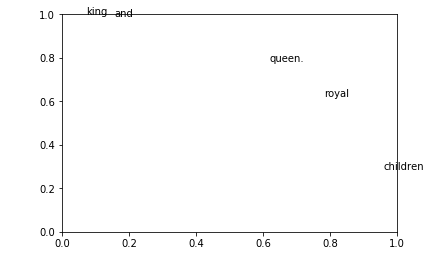

In [163]:
fig, ax = plt.subplots()
for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
plt.show()